In [60]:
import csv
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from datetime import datetime


def import_data(filename, n_wheels):
    with open(filename) as fh:
        reader = csv.reader(fh, delimiter='\t')
        rows = [[r[0]] + list(map(int, r[1:])) for r in reader]

    data = np.zeros((len(rows), n_wheels))
    for i, row in enumerate(rows):
        data[i, :] = row[1:1 + n_wheels]
    return data.T, [r[0] for r in rows]


def plot_actogram(data, times, n_wheels, animals):
    if n_wheels != len(animals):
        raise Exception("Animals doesn't match n_wheels")

    N, T = data.shape
    data /= np.max(data)
    times = [datetime.strptime(t, '%m/%d/%y %H:%M') for t in times]
    times = matplotlib.dates.date2num(times)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i in range(N):
        d = data[i, :] != 0
        plt.plot_date(times[d], data[i, d] + i, '.', markersize=2, xdate=True)

    plt.grid(which='both')

    major_ticks = np.arange(8) + .25
    minor_ticks = np.arange(32) * .25
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.set_yticklabels(animals)
    ax.grid(which='minor', alpha=0.4)

    vals = ax.get_xticks()
    minor = []
    for i, val in enumerate(vals):
        for t in range(4):
            minor.append(val + t / 4.)
    ax.set_xticks(minor, minor=True)
    ax.grid(which='minor', alpha=0.4)

    plt.tight_layout()
    plt.show()

# if __name__ == '__main__':
#     n_wheels = 8
#     animals = ['1730', '1734', '1736', '1743', '1744', '1745', '1746', '1747']
#     filename = r'E:\image j text.txt'
#     data, t = import_data(filename, n_wheels)
#     plot_actogram(data, t, n_wheels, animals)


In [62]:
03/01/21 08:00	0	2	1	3	0	0	1	2
03/01/21 08:15	1	0	2	4	1	1	3	2
03/01/21 08:30	2	1	0	2	1	2	4	3
03/01/21 08:45	1	2	1	3	0	1	2	1
03/01/21 09:00	3	2	1	2	1	3	1	2

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (3176217266.py, line 1)

In [64]:
#FUNCTION TO CLEAN A SINGLE DF
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os

col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]

for i in range(1, 33):
    col_names.append(f"Sp{i}")

file = 'Steatoda A masking 02 pm.txt'

df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
df = df.set_index('Index')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df = df[df["MonStatus"] == 1]


month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
df['DateM'] = df['DateM'].str[:3].map(month_map)
df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

df.insert(0, 'Day', df['Time'].dt.day.map(day_map))

#FUNCTION TO FILTER THRESHOLD ON A SINGLE FILE
import pandas as pd

def filter_and_merge(df, threshold=0):
    additional_columns = df.columns[:3]
    filtered_dfs = []

    for day in range(1, 9):  
        day_df = df[df['Day'] == day] 
        count_mov = day_df.filter(like="Sp")  
        x = count_mov.sum(axis=0)  
        z = x > threshold  
        columns_to_keep = z[z].index 
        
        all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
        filtered_df = day_df[all_columns_to_keep]
        filtered_dfs.append(filtered_df)

    merged_df = pd.concat(filtered_dfs)
    merged_df1 = merged_df.dropna(axis=1)
    
    return merged_df1
    
merged_df = filter_and_merge(df)

#CODE TO TEST FOR ENTRAINMENT
import numpy as np

def entrainment(data, column):
    if column not in data.columns:
        return False
    
    dflight = data[data['Light'] == 1][column]
    dfdark = data[data['Light'] == 0][column]
    
    lightmean = np.mean(dflight)
    darkmean = np.mean(dfdark)
    
    if darkmean == 0:
        return False
    
    diff = lightmean / darkmean
    return diff > 0.25

spiders = ["Sp"+str(i) for i in range(1, 33)]

entrainment_results = []

for spider_column in spiders:
    if spider_column in merged_df.columns:  # Check if the column exists
        entrainment_result = entrainment(merged_df, spider_column)
        entrainment_results.append((spider_column, entrainment_result))

results_df = pd.DataFrame(entrainment_results, columns=['Spider', 'Entrained'])

entrained_spiders = results_df[results_df['Entrained'] == True]['Spider'].tolist()

#CODE TO FILTER ENTRAINMENT
finaldf = []

additional_columns = merged_df.columns[:3]
columns_to_keep = entrained_spiders
        
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = merged_df[all_columns_to_keep]  # Use merged_df here, not entrained_spiders

finaldf.append(filtered_df)

merged_dfx = pd.concat(finaldf)
merged_dfx1 = merged_dfx.dropna(axis=1)  # Use merged_dfx here, not merged_df

display(merged_dfx1)

,Day,Time,Light,Sp3,Sp4,Sp9,Sp10,Sp12,Sp13,Sp14,Sp15,Sp16,Sp19,Sp22,Sp23
Index,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,2,2,5,0,0,0,0,0,1,3,3,0
2,1,2024-03-20 11:05:00,1,5,1,8,2,0,0,3,1,4,4,2,0
3,1,2024-03-20 11:06:00,1,3,1,8,1,0,0,5,0,1,3,5,0
4,1,2024-03-20 11:07:00,1,0,1,12,2,0,0,0,1,6,3,0,1
5,1,2024-03-20 11:08:00,1,0,1,10,0,0,0,4,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,8,2024-03-27 10:23:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10041,8,2024-03-27 10:24:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10042,8,2024-03-27 10:25:00,1,0,0,0,0,0,0,0,0,0,0,14,0


In [78]:
yy = merged_dfx1.drop(columns=['Day', 'Light'])
yy.to_csv('steatodaA.csv')

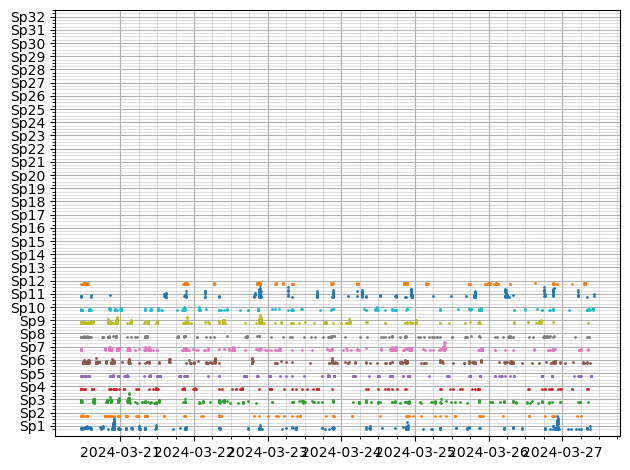

In [37]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from datetime import datetime

# Modified import_data function to handle DataFrame
def import_data_from_df(df, n_wheels):
    data = df.iloc[:, 3:3 + n_wheels].values.T  # Extracts data from columns Sp1 to Sp32 and transposes it
    times = df['Time'].astype(str).tolist()     # Converts the 'Time' column to a list of strings
    return data, times

def plot_actogram(data, times, n_wheels, animals):
    if n_wheels != len(animals):
        raise Exception("Animals doesn't match n_wheels")

    N, T = data.shape
    data = data.astype(float)  # Convert data to float for division
    data /= np.max(data)
    times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in times]  # Adjusted date format
    times = matplotlib.dates.date2num(times)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i in range(N):
        d = data[i, :] != 0
        plt.plot_date(times[d], data[i, d] + i, '.', markersize=2, xdate=True)

    plt.grid(which='both')

    major_ticks = np.arange(n_wheels) + .25
    minor_ticks = np.arange(n_wheels * 4) * .25
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.set_yticklabels(animals)
    ax.grid(which='minor', alpha=0.4)

    vals = ax.get_xticks()
    minor = []
    for i, val in enumerate(vals):
        for t in range(4):
            minor.append(val + t / 4.)
    ax.set_xticks(minor, minor=True)
    ax.grid(which='minor', alpha=0.4)

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == '__main__':
    n_wheels = 32
    animals = [f'Sp{i}' for i in range(1, 33)]
    
    # Assuming `df` is the DataFrame you've shown
    data, t = import_data_from_df(merged_dfx1, n_wheels)
    plot_actogram(data, t, n_wheels, animals)


In [38]:
#Wrong but interesting display?
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import pandas as pd

# Modified import_data function to handle DataFrame
def import_data_from_df(df, spider_index=1):
    # Ensure 'Time' is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])
    
    sp_column = f'Sp{spider_index}'
    data = df[['Time', sp_column]].copy()
    
    # Use .loc to set new columns to avoid SettingWithCopyWarning
    data.loc[:, 'Date'] = data['Time'].dt.date
    data.loc[:, 'Hour'] = data['Time'].dt.hour + data['Time'].dt.minute / 60.0
    
    # Group by date and hour and average the values
    grouped = data.groupby(['Date', 'Hour']).mean().reset_index()
    
    # Create pivot table for heatmap plotting
    pivot_table = grouped.pivot(index='Hour', columns='Date', values=sp_column).fillna(0)
    return pivot_table

def plot_actogram(pivot_table):
    plt.figure(figsize=(12, 8))
    plt.imshow(pivot_table, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Movement count')
    plt.ylabel('Hour of the day')
    plt.xlabel('Day')
    plt.title('Actogram')
    
    # Set x-ticks and y-ticks
    plt.xticks(np.arange(len(pivot_table.columns)), pivot_table.columns, rotation=45)
    plt.yticks(np.arange(0, 24, 1))
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == '__main__':
    # Assuming `df` is the DataFrame you've shown
    spider_index = 1  # You can change this to any spider index you want to plot
    pivot_table = import_data_from_df(merged_dfx1, spider_index)
    plot_actogram(pivot_table)


KeyError: "['Sp1'] not in index"

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from datetime import datetime

# Modified import_data function to handle DataFrame
def import_data_from_df(df, spider_col):
    data = df[spider_col].values  # Extracts data from a single spider column
    times = df['Time'].astype(str).tolist()  # Converts the 'Time' column to a list of strings
    return data, times

def plot_actogram(data, times, spider_name):
    # Convert times to datetime objects
    times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in times]
    
    # Convert times to numerical format for plotting
    times_num = matplotlib.dates.date2num(times)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Average the movement count over each hour
    hourly_data = []
    hourly_times = []
    current_hour = times[0].replace(minute=0, second=0, microsecond=0)
    current_sum = 0
    current_count = 0

    for t, d in zip(times, data):
        if t.replace(minute=0, second=0, microsecond=0) == current_hour:
            current_sum += d
            current_count += 1
        else:
            if current_count > 0:
                hourly_data.append(current_sum / current_count)
                hourly_times.append(current_hour)
            current_hour = t.replace(minute=0, second=0, microsecond=0)
            current_sum = d
            current_count = 1

    if current_count > 0:
        hourly_data.append(current_sum / current_count)
        hourly_times.append(current_hour)

    hourly_times_num = matplotlib.dates.date2num(hourly_times)
    
    # Plot the data
    ax.plot_date(hourly_times_num, hourly_data, '-', markersize=2, xdate=True)

    # Set labels and grid
    ax.set_ylabel('Activity')
    ax.set_xlabel('Time')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    
    # Set y-axis to show days
    days = [dt.strftime('%Y-%m-%d') for dt in matplotlib.dates.num2date(hourly_times_num)]
    unique_days = np.unique(days)
    ax.set_yticks(range(len(unique_days)))
    ax.set_yticklabels(unique_days)
    
    plt.tight_layout()
    plt.title(f'Actogram for {spider_name}')
    plt.grid()
    plt.show()

# Example usage
if __name__ == '__main__':
    # Assuming `df` is the DataFrame you've shown
    spider_col = 'Sp3'  # Change this to the desired spider column (e.g., 'Sp1', 'Sp2', ...)
    spider_name = spider_col
    data, t = import_data_from_df(merged_dfx1, spider_col)
    plot_actogram(data, t, spider_name)


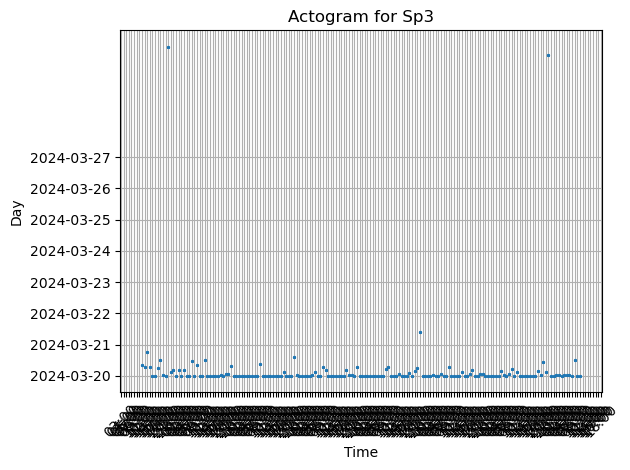

In [39]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Modified import_data function to handle DataFrame
def import_data_from_df(df, spider_col):
    data = df[spider_col].values  # Extracts data from a single spider column
    times = df['Time'].astype(str).tolist()  # Converts the 'Time' column to a list of strings
    return data, times

def plot_actogram_single_spider(data, times, spider_name):
    # Convert times to datetime objects
    times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in times]
    
    # Group data by day and hour
    day_hour_data = {}
    for t, d in zip(times, data):
        day_hour = (t.date(), t.hour)
        if day_hour not in day_hour_data:
            day_hour_data[day_hour] = []
        day_hour_data[day_hour].append(d)
    
    # Calculate average activity for each hour
    hourly_average_activity = []
    hourly_times = []
    for day_hour, day_data in day_hour_data.items():
        hourly_average_activity.append(np.mean(day_data))
        hourly_times.append(datetime.combine(day_hour[0], datetime.min.time()) + timedelta(hours=day_hour[1]))
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.plot_date(hourly_times, hourly_average_activity, '*', markersize=2)
    
    # Set x-axis to show time
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    
    # Set y-axis to show days
    days = [dt.date() for dt in hourly_times]
    unique_days = np.unique(days)
    ax.set_yticks(range(len(unique_days)))
    ax.set_yticklabels(unique_days)
    
    plt.title(f'Actogram for {spider_name}')
    plt.xlabel('Time')
    plt.ylabel('Day')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == '__main__':
    spider_col = 'Sp3'  # Change this to the desired spider column (e.g., 'Sp1', 'Sp2', ...)
    spider_name = spider_col
    data, t = import_data_from_df(merged_dfx1, spider_col)
    plot_actogram_single_spider(data, t, spider_name)

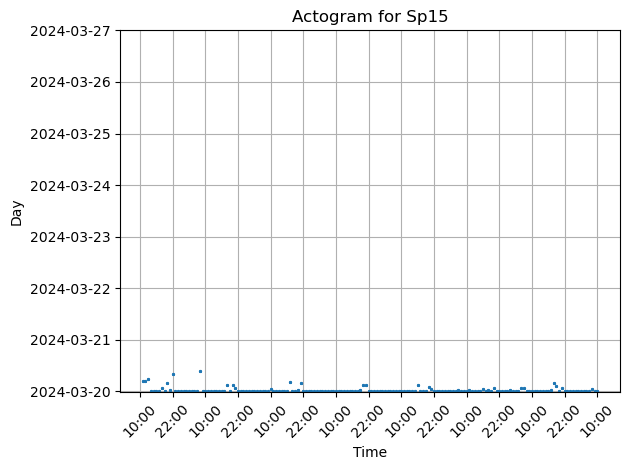

In [106]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Modified import_data function to handle DataFrame
def import_data_from_df(df, spider_col):
    data = df[spider_col].values  # Extracts data from a single spider column
    times = df['Time'].astype(str).tolist()  # Converts the 'Time' column to a list of strings
    return data, times

def plot_actogram_single_spider(data, times, spider_name):
    # Convert times to datetime objects
    times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in times]
    
    # Group data by day and hour
    day_hour_data = {}
    for t, d in zip(times, data):
        day_hour = (t.date(), t.hour)
        if day_hour not in day_hour_data:
            day_hour_data[day_hour] = []
        day_hour_data[day_hour].append(d)
    
    # Calculate average activity for each hour
    hourly_average_activity = []
    hourly_times = []
    for day_hour, day_data in day_hour_data.items():
        hourly_average_activity.append(np.mean(day_data))
        hourly_times.append(datetime.combine(day_hour[0], datetime.min.time()) + timedelta(hours=day_hour[1]))
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.plot_date(hourly_times, hourly_average_activity, '*', markersize=2)
    
    # Set x-axis ticks to be at 0, 12, 24 for each day
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    
    # Set y-axis to show days
    days = [dt.date() for dt in hourly_times]
    unique_days = np.unique(days)
    ax.set_yticks(range(len(unique_days)))
    ax.set_yticklabels(unique_days)
    
    plt.title(f'Actogram for {spider_name}')
    plt.xlabel('Time')
    plt.ylabel('Day')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == '__main__':
    spider_col = 'Sp15'  # Change this to the desired spider column (e.g., 'Sp1', 'Sp2', ...)
    spider_name = spider_col
    data, t = import_data_from_df(merged_dfx1, spider_col)
    plot_actogram_single_spider(data, t, spider_name)


In [94]:
def plot_actogram_single_spider(data, times, spider_name):
    # Convert times to datetime objects
    times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in times]
    
    # Group data by day and hour
    day_hour_data = {}
    for t, d in zip(times, data):
        day_hour = (t.date(), t.hour)
        if day_hour not in day_hour_data:
            day_hour_data[day_hour] = []
        day_hour_data[day_hour].append(d)
    
    # Calculate average activity for each hour
    hourly_average_activity = []
    hourly_times = []
    for day_hour, day_data in day_hour_data.items():
        hourly_average_activity.append(np.mean(day_data))
        hourly_times.append(datetime.combine(day_hour[0], datetime.min.time()) + timedelta(hours=day_hour[1]))
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.plot_date(hourly_times, hourly_average_activity, '*', markersize=2)
    
    # Set x-axis ticks to be at 0, 12, 24 for each day
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    
    # Set y-axis to show days
    days = [dt.date() for dt in hourly_times]
    unique_days = np.unique(days)
    ax.set_yticks(range(len(unique_days)))
    ax.set_yticklabels(unique_days)
    
    plt.title(f'Actogram for {spider_name}')
    plt.xlabel('Time')
    plt.ylabel('Day')
    plt.grid()
    plt.tight_layout()
    plt.show()


In [43]:
import csv
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from datetime import datetime
sunlines = [{'rising': True,
             'angle': 12,
             'minutes': 60,
             'style': {
                 'color': 'black',
                 'linewidth': 2.0,
                 'alpha': 0.5
             }
           }]
plt.actogram(merged_dfx1, cmap = "binary", sunlines = sunlines)

AttributeError: module 'matplotlib.pylab' has no attribute 'actogram'

In [ ]:
import pandas as pd

# Define the data
data = {
    'Time': ['4/10/24 9:38', '4/10/24 9:39', '4/10/24 9:40', '4/10/24 9:41', '4/10/24 9:42'],
    '1730': [1, 1, 1, 1, 1],
    '1734': [9, 0, 0, 0, 2],
    '1736': [1, 0, 0, 0, 0],
    '1743': [2, 0, 0, 0, 0],
    '1744': [3, 4, 8, 2, 6],
    '1745': [1, 2, 0, 7, 2],
    '1746': [2, 0, 1, 0, 2],
    '1747': [1, 3, 3, 4, 2]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)


In [ ]:
if __name__ == '__main__':
    n_wheels = "1746"
    animals = ['1730', '1734', '1736', '1743', '1744', '1745', '1746', '1747']
    
    # Assuming `df` is the DataFrame you already have
    data, t = import_data_from_df(df, n_wheels)
    plot_actogram(data, t, n_wheels, animals)



In [86]:
# Step 1: Prepare Your Data
# Ensure your data is in a format similar to the example provided in the import_data function.

# Step 2: Modify import_data Function
# Adjust the import_data function to read your data file format and parse your data correctly.

# Step 3: Adjust Parameters
n_wheels = 12  # Set the number of animals in your dataset
animals = ['Sp3', 'Sp4', 'Sp9', 'Sp10',	'Sp12', 'Sp13', 'Sp14', 'Sp15', 'Sp16', 'Sp19', 'Sp22', 'Sp23']  # Provide a list of animal IDs

# Step 4: Run the Script
# Call the import_data function with your data file path and n_wheels
# Call the plot_actogram function with the imported data and parameters
data, t = import_data('steatodaA.csv', n_wheels)
plot_actogram(data, t, n_wheels, animals)


ValueError: could not broadcast input array from shape (0,) into shape (12,)

In [124]:
def double_plotted_actogram(sp, fig):
    days = merged_dfx1['Day'].unique()
    for j, day in enumerate(days):
        curr_df = merged_dfx1[merged_dfx1['Day'] == day]
        
        ax = fig.add_subplot(len(days), 1, j + 1)
        ax.set_ylabel(f"Day {day}", rotation="horizontal", va="center", ha="right", fontsize=8)

        for k in range(len(curr_df) - 1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        # Plot activity data
        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
        ax.plot(curr_df_avg.index, curr_df_avg.values, '.', markersize=2)
    
        ax.set_ylim(0, 1)
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == 0:
            ax.set_title(sp)
        
        if j == len(days) - 1:
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation='horizontal', fontsize=7)
            ax.set_xlabel('Time (hours)')

    plt.tight_layout()
    plt.show()
    # if not os.path.exists("Actogram_plots"):
    #     os.makedirs("Actogram_plots")
    
    # file_path = os.path.join("Actogram_plots", f"{sp}_double_actogram.png")
    # plt.savefig(file_path)
    # plt.close()
for i in range(1, 12):
    x = f"Sp{i}"
    fig = plt.figure(figsize=(4, 6))
    double_plotted_actogram(x, fig)

KeyError: 'Column not found: Sp1'

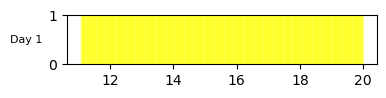

In [128]:
for i in range(1, 12):
    x = f"Sp{i}"
    fig = plt.figure(figsize=(4, 6))
    double_plotted_actogram(x, fig)

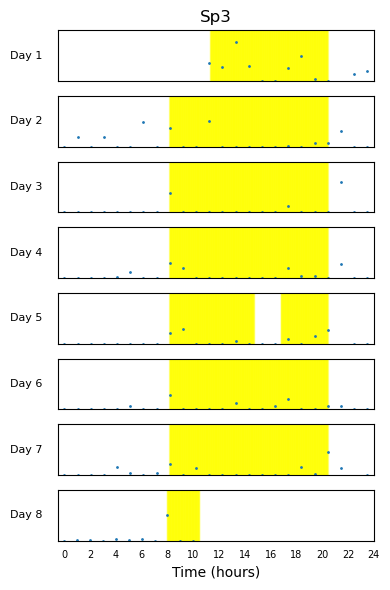

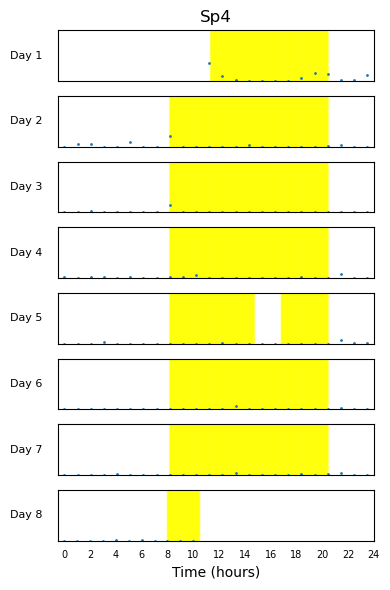

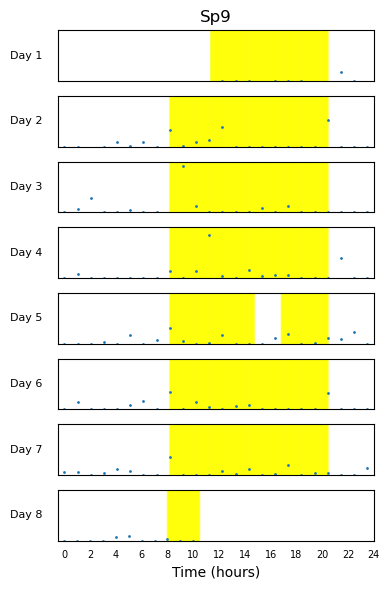

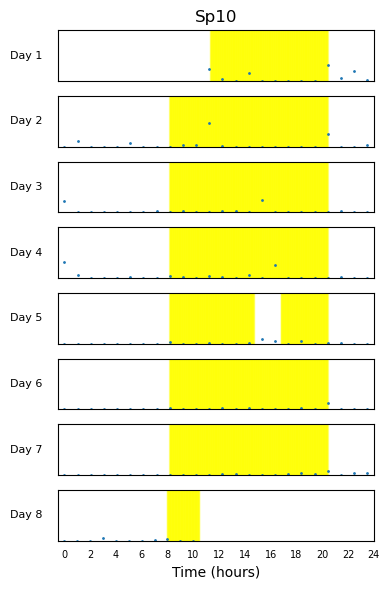

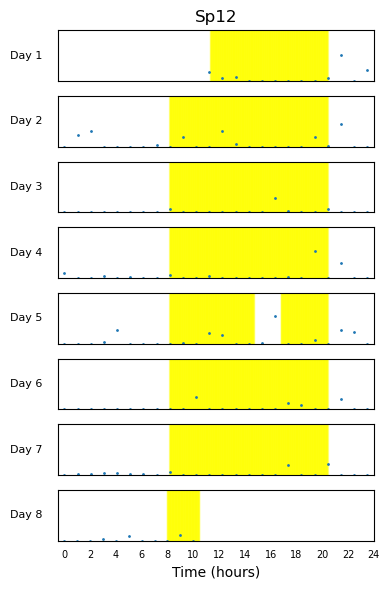

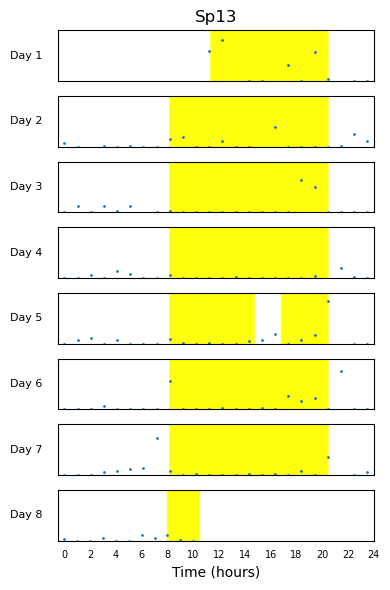

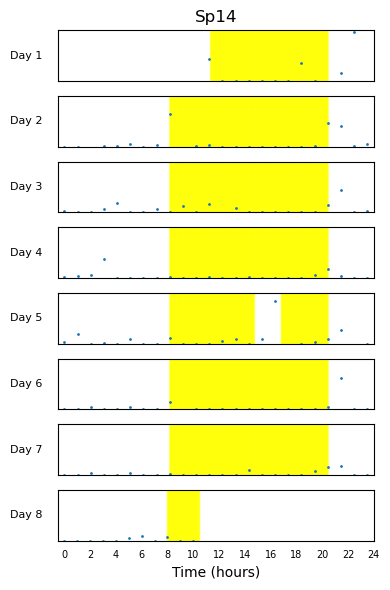

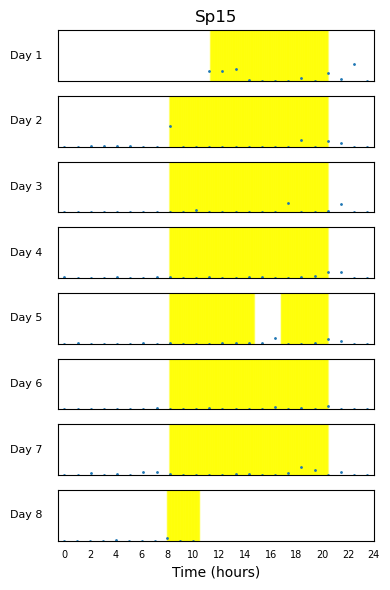

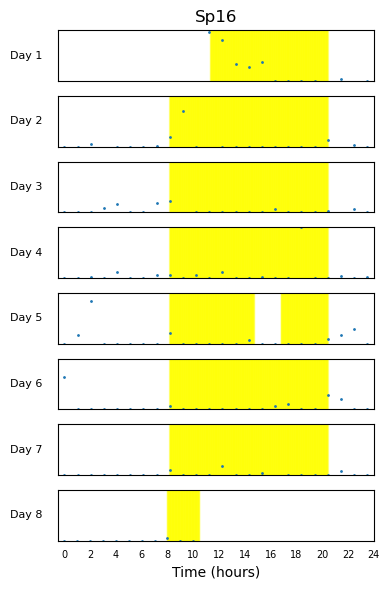

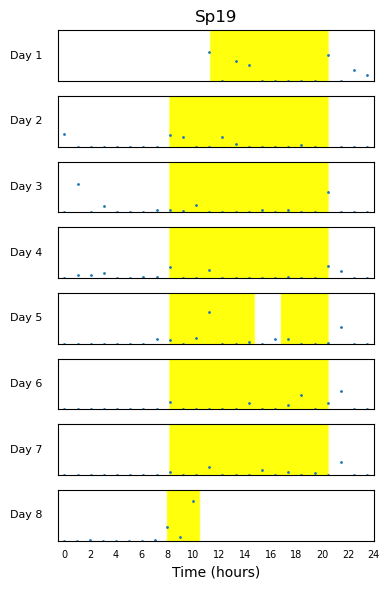

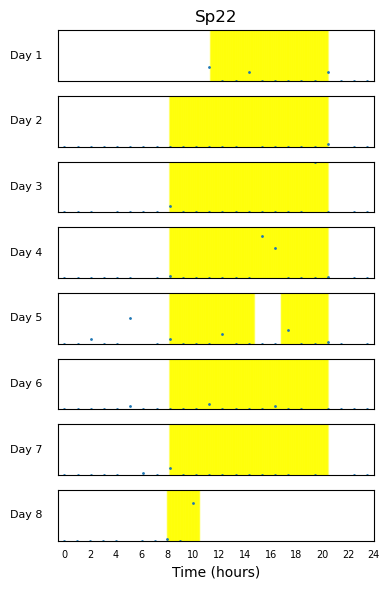

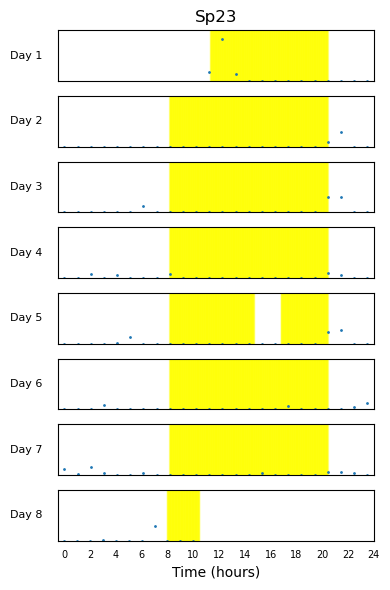

In [130]:
import matplotlib.pyplot as plt
import numpy as np

def double_plotted_actogram(sp, fig):
    days = merged_dfx1['Day'].unique()
    for j, day in enumerate(days):
        curr_df = merged_dfx1[merged_dfx1['Day'] == day]
        
        ax = fig.add_subplot(len(days), 1, j + 1)
        ax.set_ylabel(f"Day {day}", rotation="horizontal", va="center", ha="right", fontsize=8)

        for k in range(len(curr_df) - 1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        # Plot activity data
        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
        ax.plot(curr_df_avg.index, curr_df_avg.values, '.', markersize=2)
    
        ax.set_ylim(0, 1)
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == 0:
            ax.set_title(sp)
        
        if j == len(days) - 1:
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation='horizontal', fontsize=7)
            ax.set_xlabel('Time (hours)')
        else:
            ax.set_xticks([])
            ax.set_xticklabels([])

    plt.tight_layout()
    plt.show()
    # if not os.path.exists("Actogram_plots"):
    #     os.makedirs("Actogram_plots")
    
    # file_path = os.path.join("Actogram_plots", f"{sp}_double_actogram.png")
    # plt.savefig(file_path)
    # plt.close()

# Example usage
# Dynamically find spider columns
spider_columns = [col for col in merged_dfx1.columns if col.startswith('Sp')]

for sp in spider_columns:
    fig = plt.figure(figsize=(4, 6))
    double_plotted_actogram(sp, fig)
